In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
def append_ones(matrix, axis=1):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)


def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)


def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)


def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)


def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]

    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (examples[r, c] - ex_min) / (ex_max - ex_min)

    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

# MNIST dataset

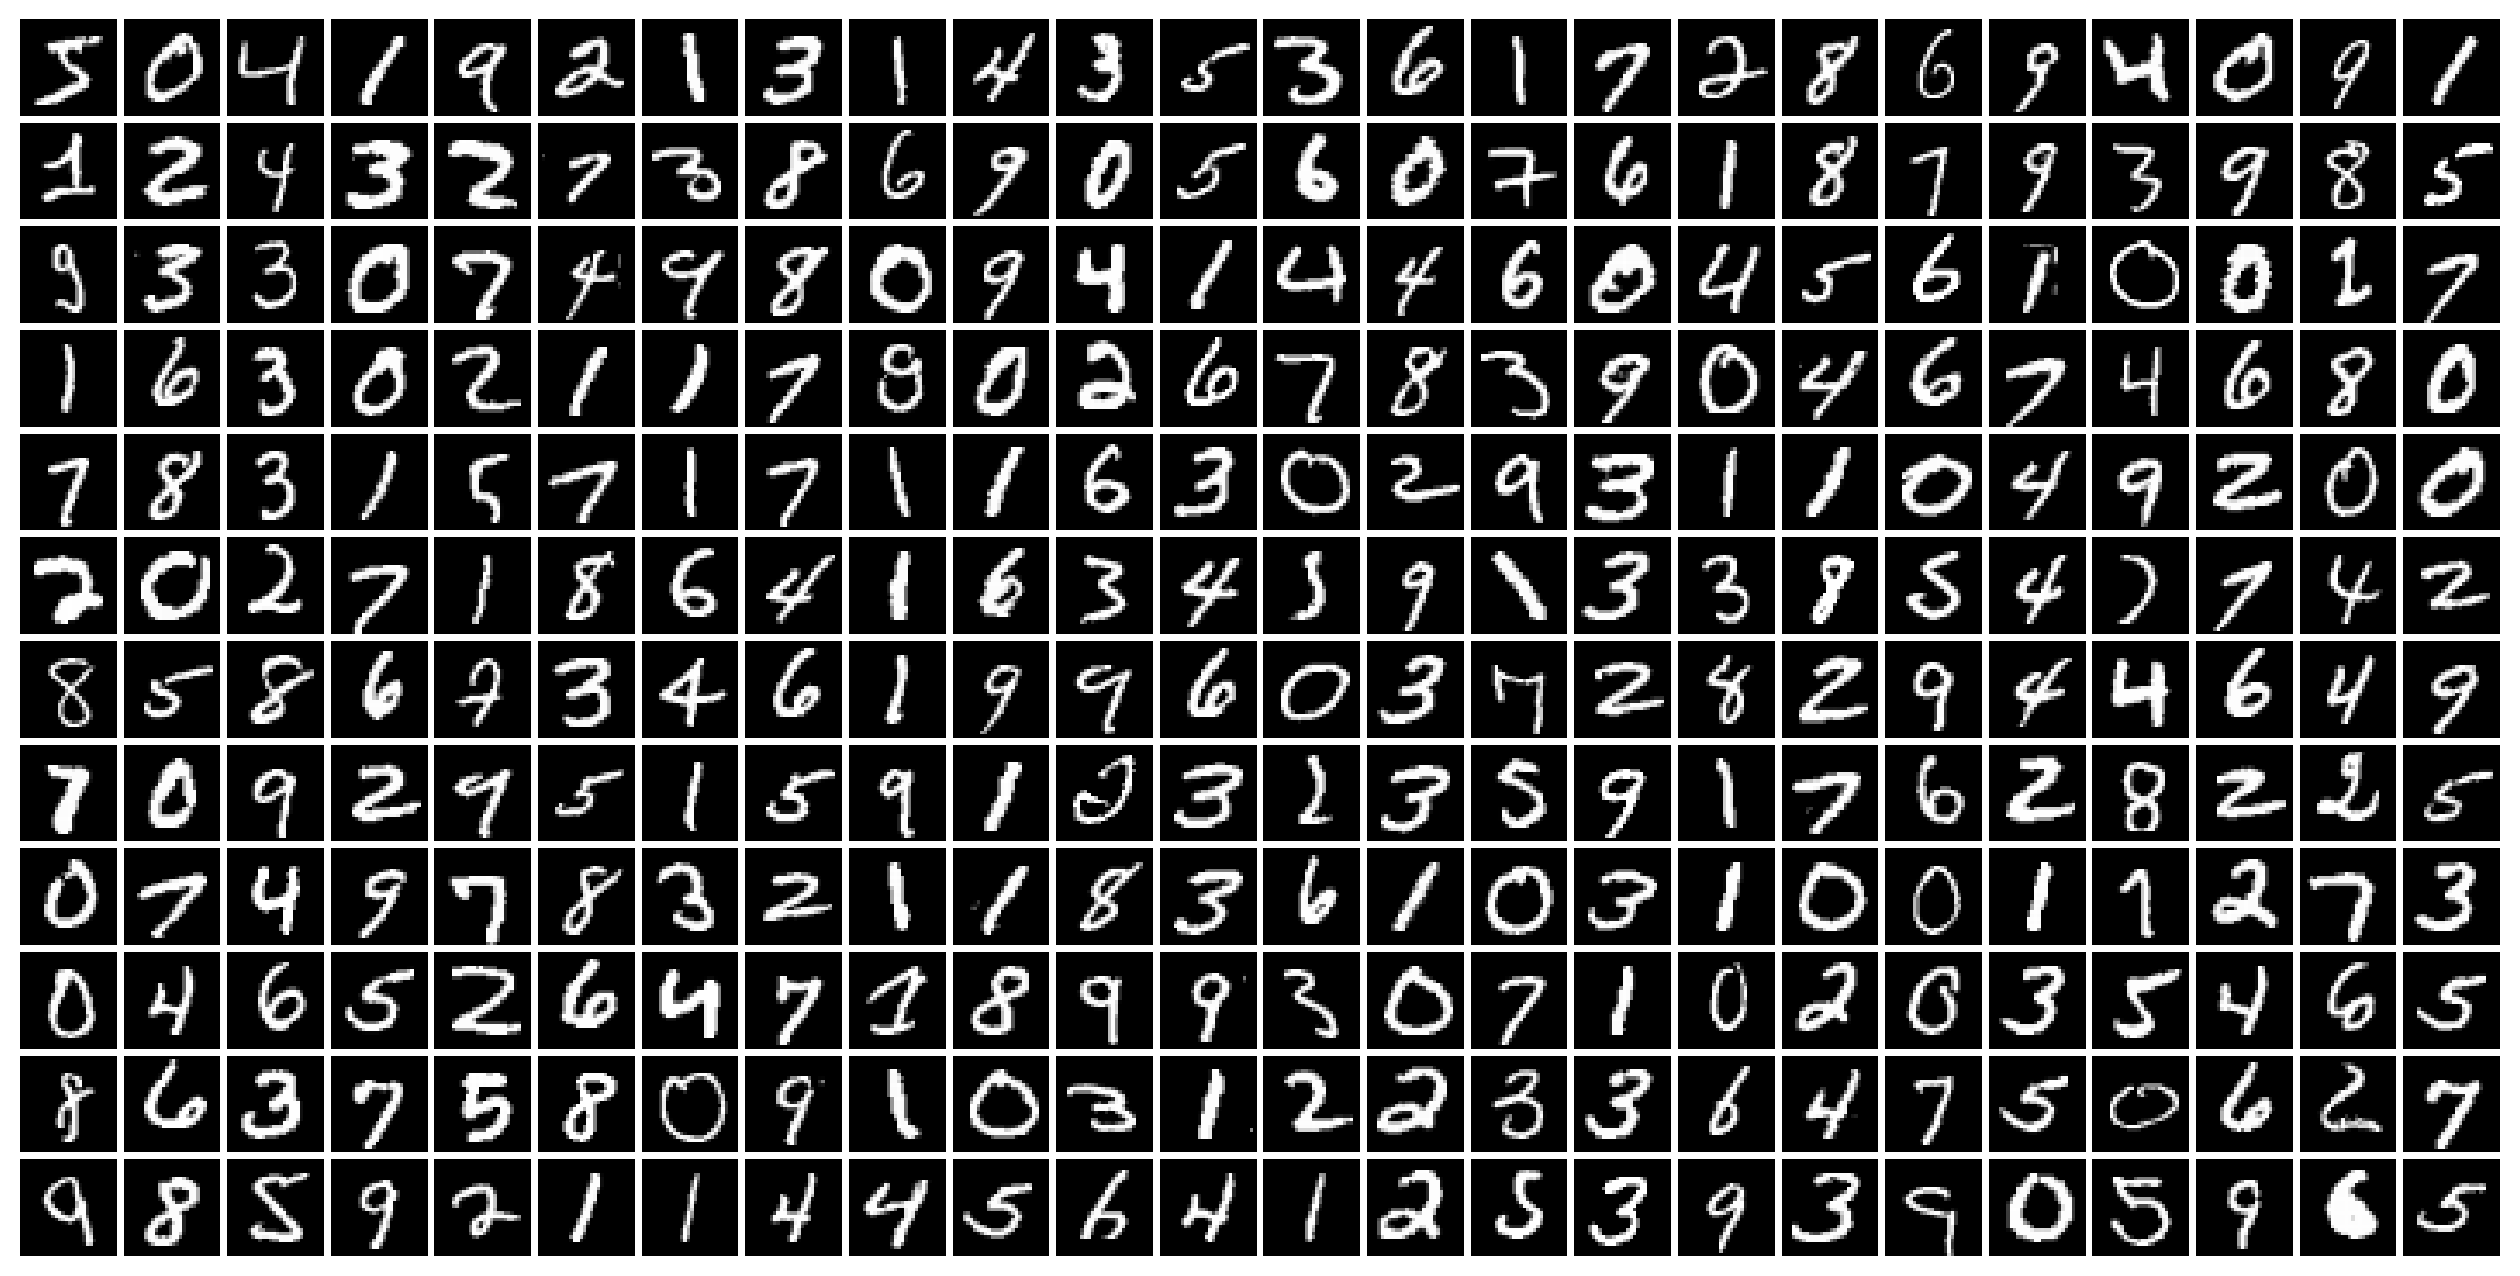

In [3]:
import mnist

digits = np.reshape(mnist.train_images()[:12 * 24], newshape=(12, 24, 28, 28))
tiles(digits)

# Restricted Boltzmann Machine & Contrastive Divergence algorithm

In [4]:
def sigmoid(matrix):
    return 1.0 / (1.0 + np.exp(-matrix))


class Rbm:
    def __init__(self, visible_size, hidden_size, learning_rate, momentum):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.momentum = momentum

        self.reset()

    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size + 1, self.hidden_size + 1)).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0
        self.M = zeros(self.visible_size + 1, self.hidden_size + 1)

In [5]:
def reconstruction_error(rbm, minibatch):
    observations_count = minibatch.shape[0]
    visible = append_ones(zeros(observations_count, rbm.visible_size))
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    hidden[:, :-1] = sigmoid(minibatch @ rbm.W[:, :-1])
    hidden[:, :-1] = (hidden[:, :-1] > rand(observations_count, rbm.hidden_size)).astype(np.float32)

    visible = sigmoid(hidden @ rbm.W[:-1, :].T)

    error = np.sum((minibatch[:, :-1] - visible) ** 2) / observations_count

    return error

In [6]:
def train_epoch(rbm, dataset, batch_size):
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(rbm, batch)
        if batch_idx % round(batches_limit / 50) == 0: print("#", end="")


def run_training(rbm, dataset, monitoring_set, batch_size, epochs_count):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch), end="\t")

        if epoch == 5:
            rbm.momentum = 0.8

        start_time = time.time()
        train_epoch(rbm, dataset, batch_size)
        elapsed = time.time() - start_time

        error = reconstruction_error(rbm, monitoring_set)
        print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

    print("Training finished!")

In [7]:
def draw_filters(rbm):
    filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))
    tiles(filters)

# 1. RBM Training with momentum

In [8]:
def cdk(rbm, minibatch, k=1):
    observations_count = minibatch.shape[0]

    # activation matrices during positive and negative phase in visible v layer with bias
    positive_visible = minibatch
    negative_visible = append_ones(zeros(observations_count, rbm.visible_size))

    # activation matrices during positive and negative phase in hidden h layer with bias
    positive_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    negative_hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    # positive phase
    positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
    positive_gradient = (positive_visible.T @ positive_hidden) / observations_count

    # negative phase
    negative_hidden[:, :-1] = (positive_hidden[:, :-1] >
                               rand(observations_count, rbm.hidden_size)).astype(np.float32)

    for cd in range(k):
        negative_visible[:, :-1] = sigmoid(negative_hidden @ rbm.W[:-1, :].T)
        negative_visible[:, :-1] = (negative_visible[:, :-1] >
                                    rand(observations_count, rbm.visible_size)).astype(np.float32)

        negative_hidden[:, :-1] = sigmoid(negative_visible @ rbm.W[:, :-1])
        if cd < k - 1:
            negative_hidden[:, :-1] = (negative_hidden[:, :-1] >
                                       rand(observations_count, rbm.hidden_size)).astype(np.float32)

    negative_gradient = (negative_visible.T @ negative_hidden) / observations_count

    # update weights with momentum
    rbm.M = rbm.momentum * rbm.M + rbm.learning_rate * (positive_gradient - negative_gradient)
    rbm.W += rbm.M

In [9]:
import time

DATASET_SIZE = 20000  # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE * DIGIT_SIZE
HIDDEN_LAYER_SIZE = 128

mnist_train = mnist.train_images().astype(np.float32) / 255.0
np.random.shuffle(mnist_train)
dataset = np.reshape(mnist_train[:DATASET_SIZE], newshape=(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE))
dataset = append_ones(dataset)

monitoring_indeces = np.random.choice(DATASET_SIZE, 256, replace=False)
monitoring_set = dataset[monitoring_indeces]

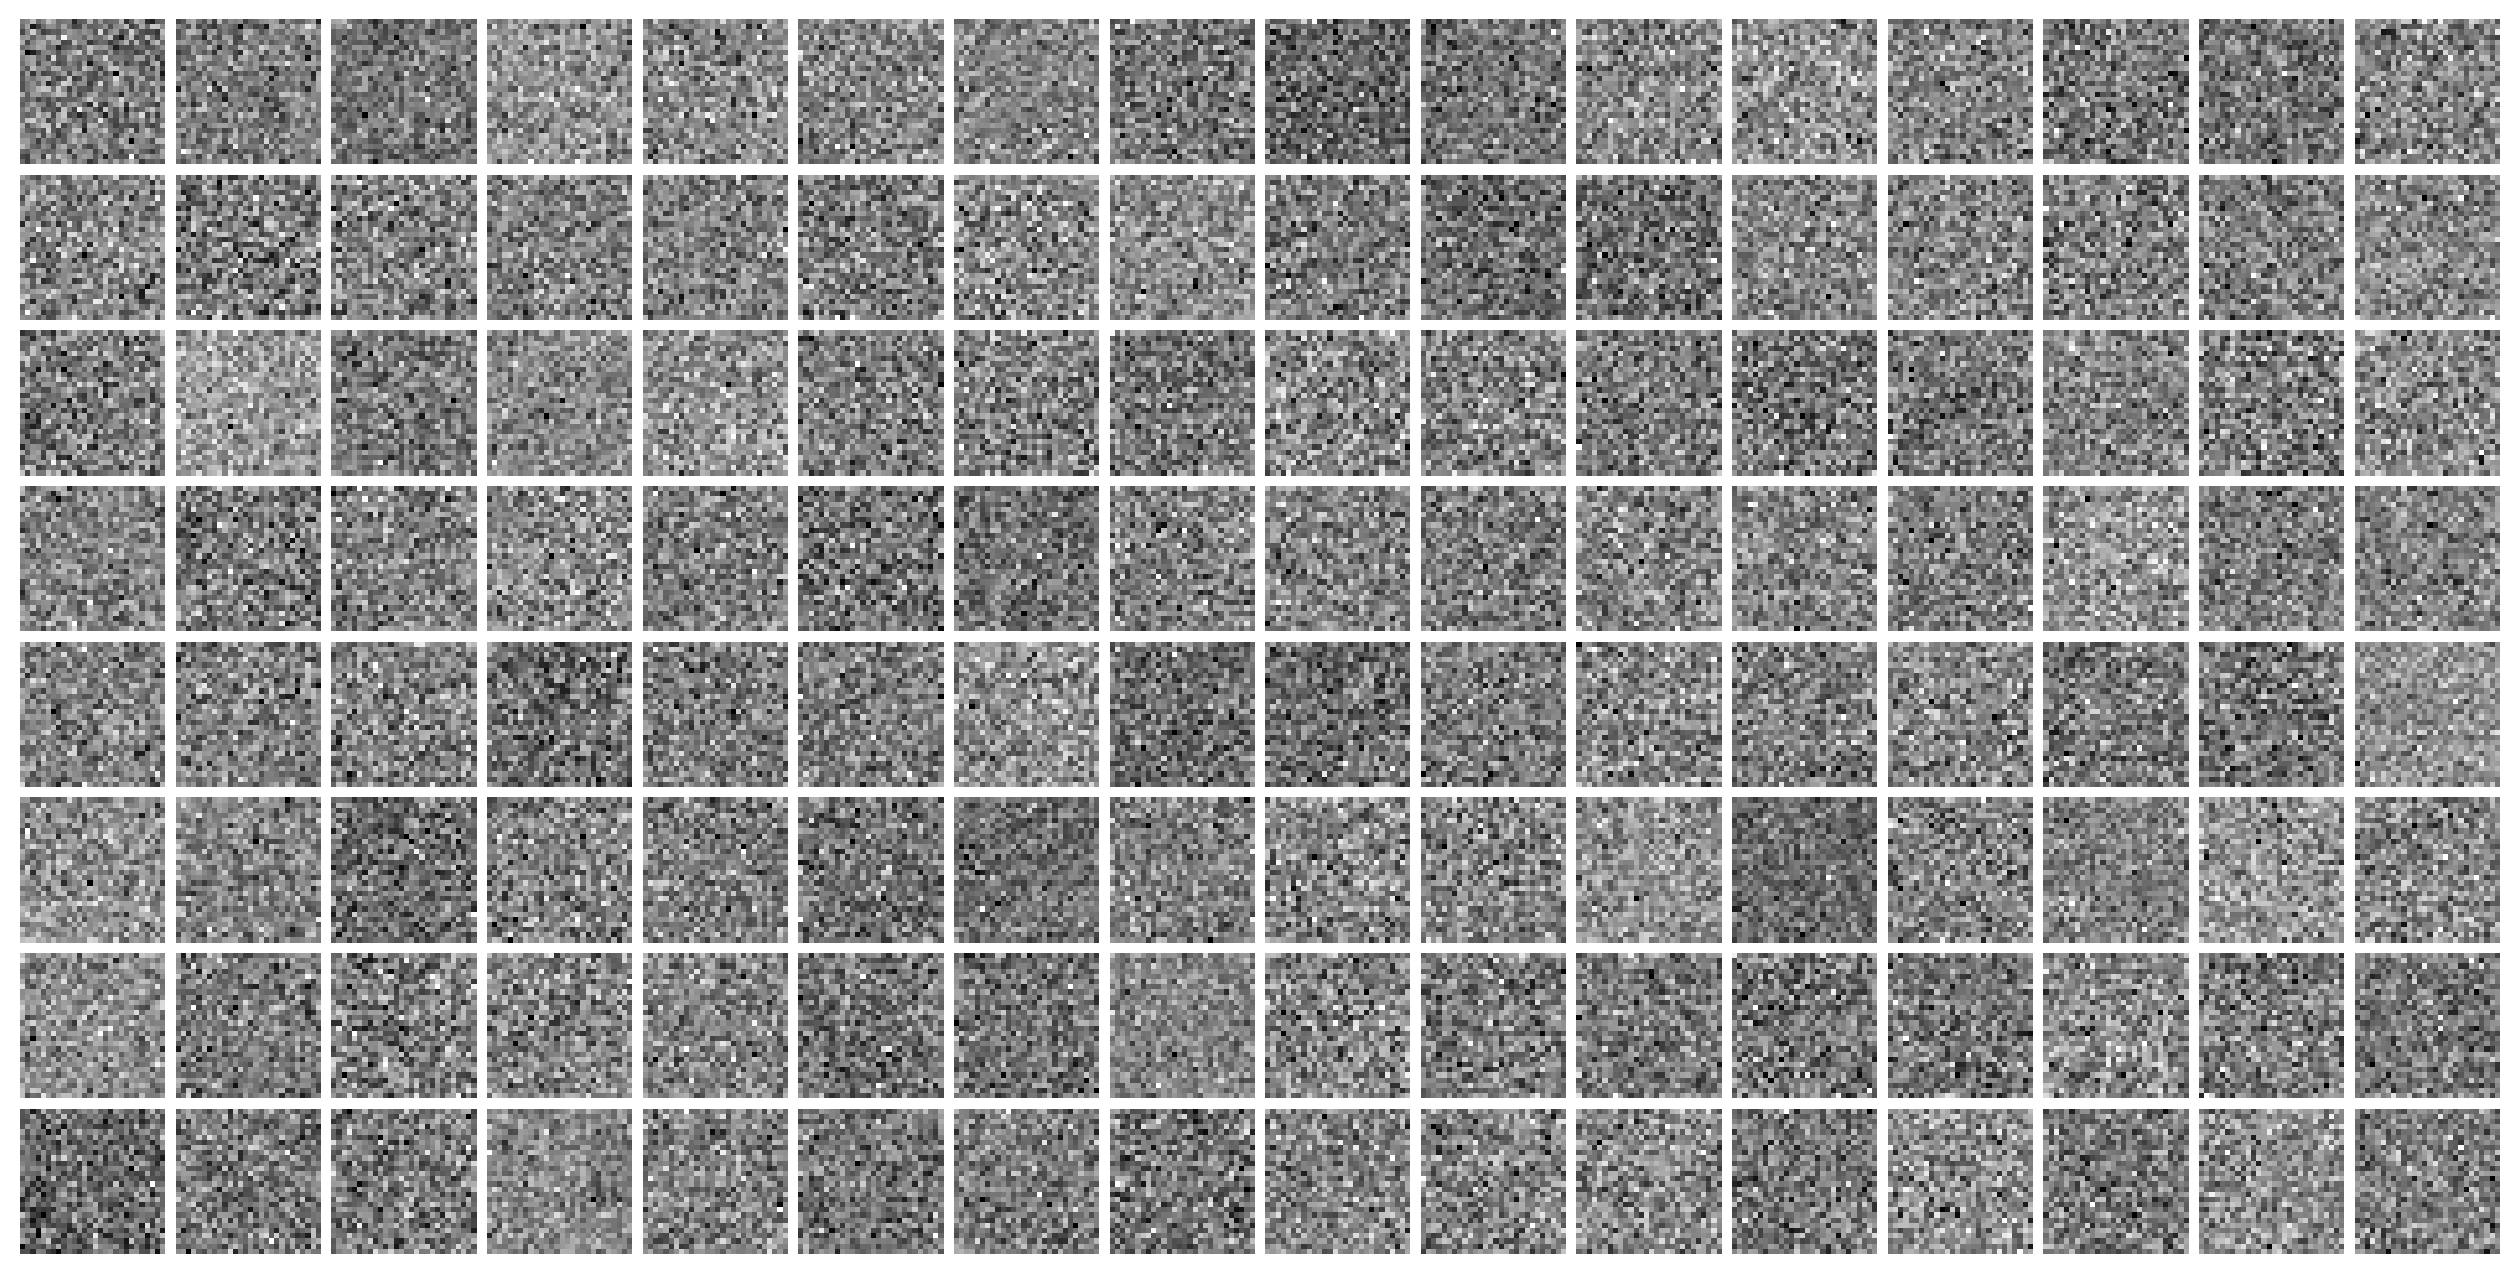

Epoch 0:	#####################################################	elapsed: 0.57s, reconstruction error: 26.50
Epoch 1:	#####################################################	elapsed: 0.68s, reconstruction error: 21.39
Epoch 2:	#####################################################	elapsed: 0.50s, reconstruction error: 18.78
Epoch 3:	#####################################################	elapsed: 0.61s, reconstruction error: 17.27
Epoch 4:	#####################################################	elapsed: 0.67s, reconstruction error: 16.32
Epoch 5:	#####################################################	elapsed: 0.83s, reconstruction error: 15.00
Epoch 6:	#####################################################	elapsed: 0.57s, reconstruction error: 13.98
Epoch 7:	#####################################################	elapsed: 0.59s, reconstruction error: 13.31
Epoch 8:	#####################################################	elapsed: 0.54s, reconstruction error: 12.85
Epoch 9:	############################

/tmp/ipykernel_9281/3913008747.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-matrix))


###########################################	elapsed: 0.53s, reconstruction error: 10.58
Epoch 35:	#####################################################	elapsed: 0.52s, reconstruction error: 10.35
Epoch 36:	#####################################################	elapsed: 0.58s, reconstruction error: 10.39
Epoch 37:	#####################################################	elapsed: 0.44s, reconstruction error: 10.44
Epoch 38:	#####################################################	elapsed: 0.74s, reconstruction error: 10.42
Epoch 39:	#####################################################	elapsed: 1.17s, reconstruction error: 10.19
Epoch 40:	#####################################################	elapsed: 0.56s, reconstruction error: 10.48
Epoch 41:	#####################################################	elapsed: 1.03s, reconstruction error: 10.35
Epoch 42:	#####################################################	elapsed: 0.73s, reconstruction error: 10.33
Epoch 43:	######################################

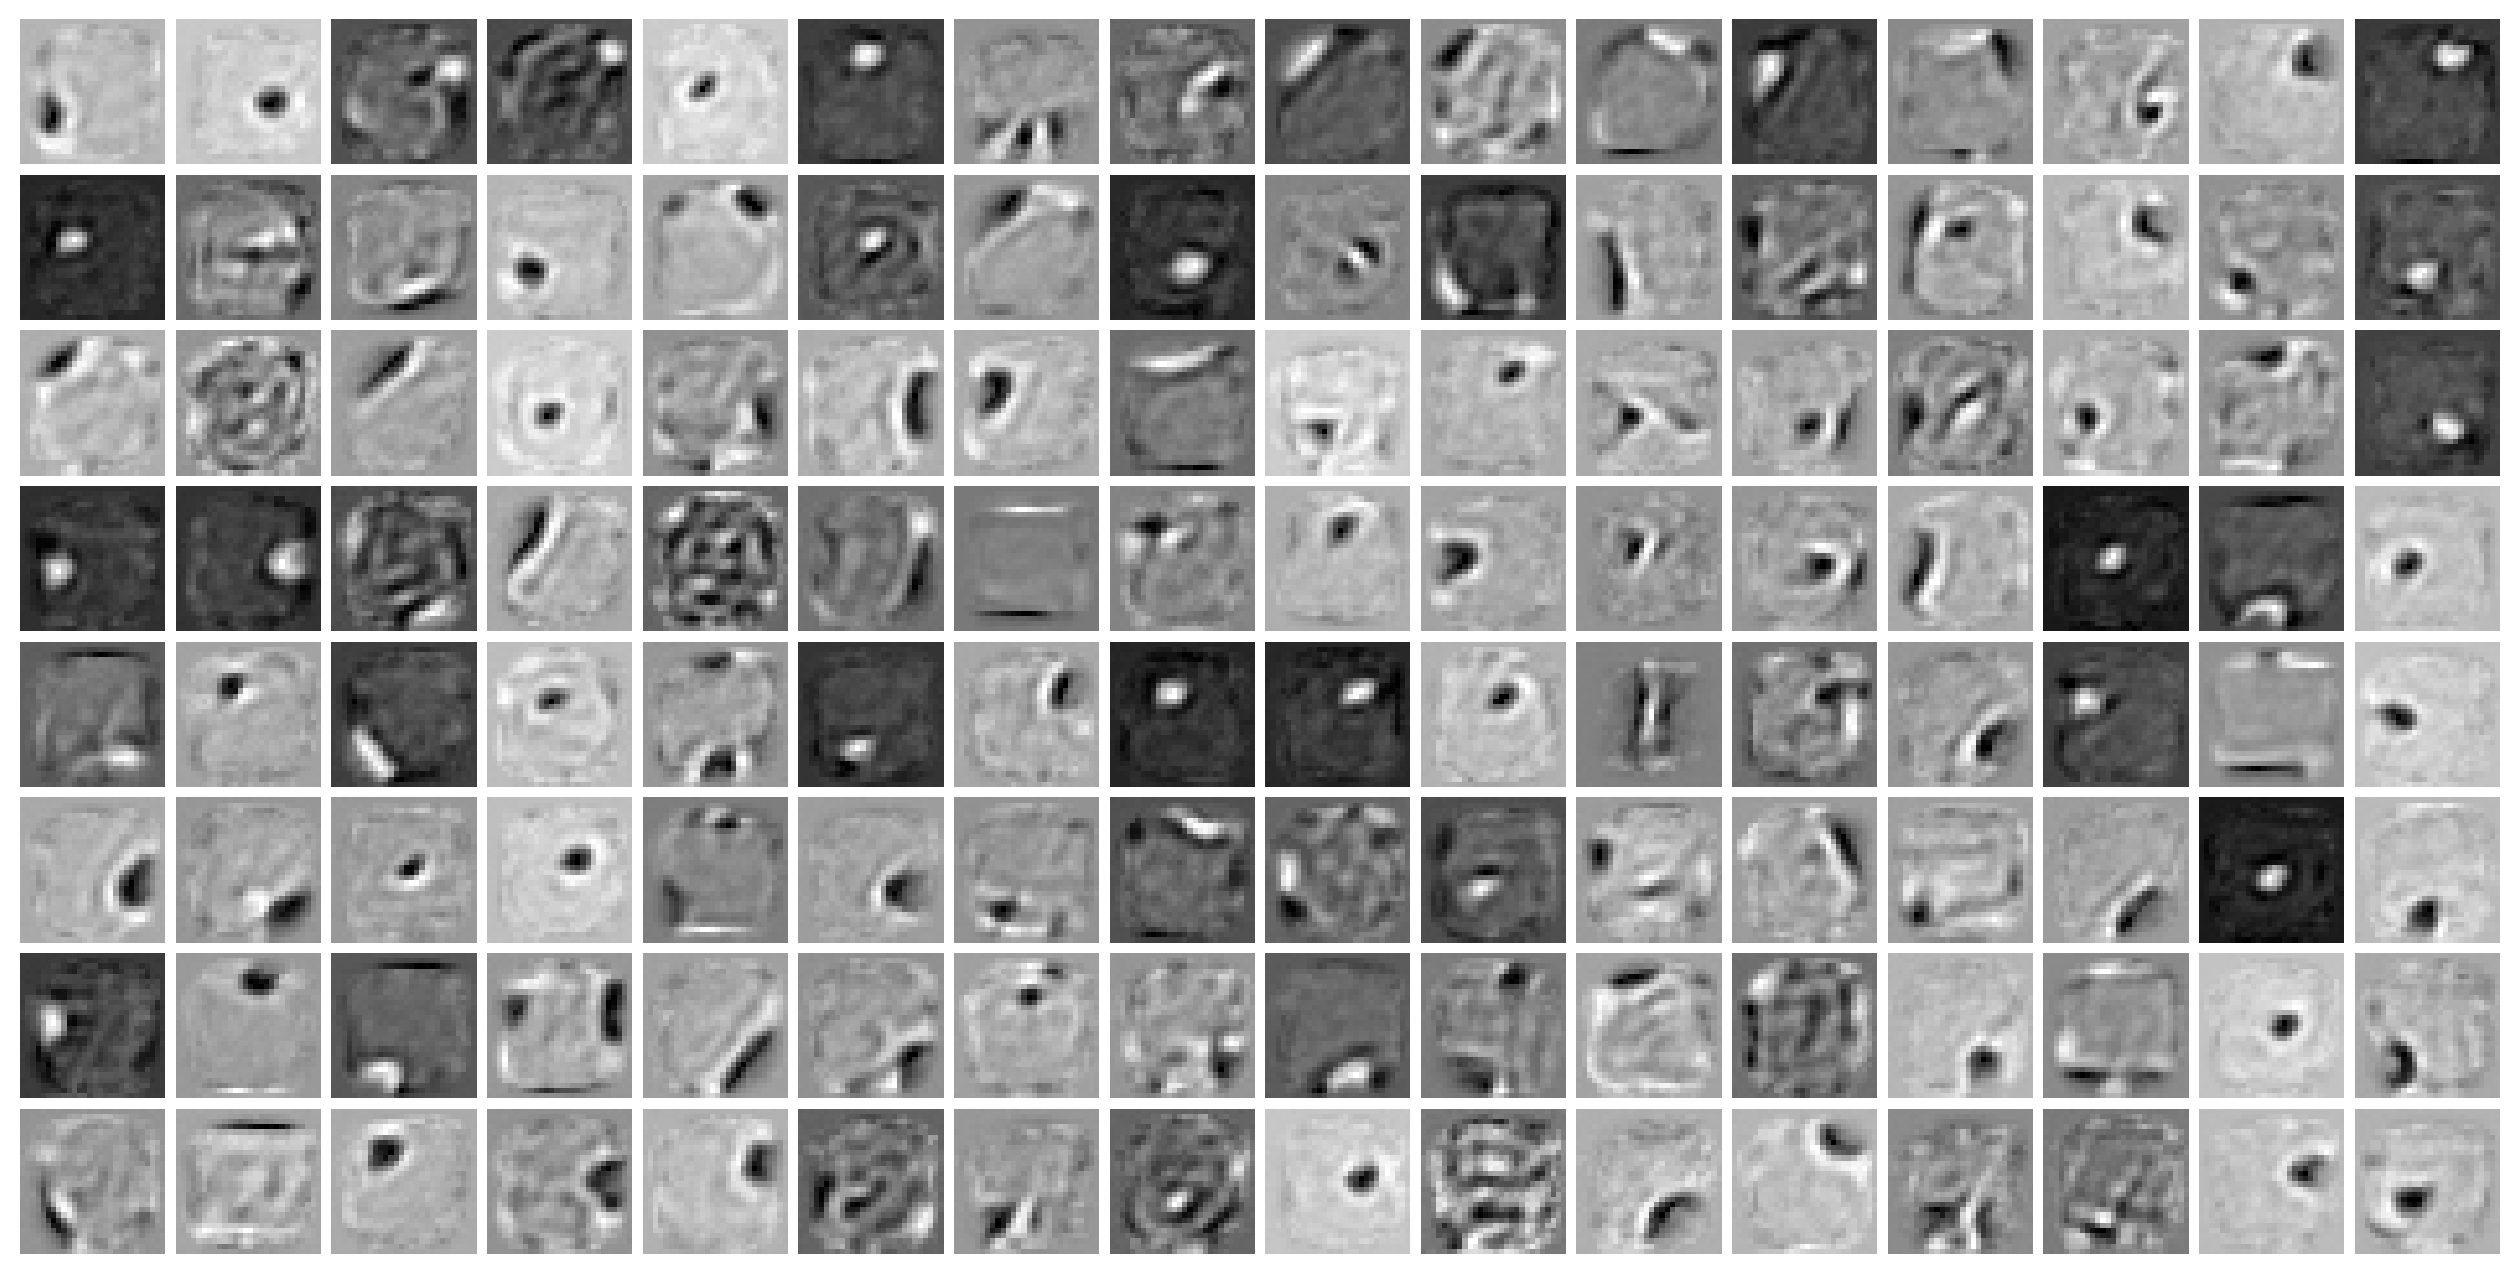

In [10]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
MOMENTUM = 0.5

rbm = Rbm(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM)
draw_filters(rbm)

run_training(rbm, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT)

draw_filters(rbm)

# 2. DBN Training

In [11]:
def propagate_up(dbn, layers_count, visible):
    for i in range(layers_count):
        visible = append_ones(sigmoid(visible @ dbn[i].W[:, :-1]))
    return visible


def propagate_down(dbn, layers_count, hidden):
    for i in reversed(range(layers_count)):
        hidden = append_ones(sigmoid(hidden @ np.transpose(dbn[i].W[:-1, :])))
    return hidden

### DBN reconstruction error

In [12]:
def dbn_reconstruction_error(dbn, layers_count, minibatch):
    prop_up = propagate_up(dbn, layers_count, minibatch)
    return reconstruction_error(dbn[layers_count], prop_up)

### Sampling in Deep Belief Networks

In [13]:
def sample_rbm(rbm, minibatch, steps):
    observations_count = minibatch.shape[0]

    visible = minibatch
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    for cd_i in range(steps):
        hidden[:, :-1] = sigmoid(visible @ rbm.W[:, :-1])
        hidden[:, :-1] = (hidden[:, :-1] > rand(observations_count, rbm.hidden_size)).astype(np.float32)

        visible[:, :-1] = sigmoid(hidden @ np.transpose(rbm.W[:-1, :]))
        if cd_i < (steps - 1):
            visible[:, :-1] = (visible[:, :-1] > rand(observations_count, rbm.visible_size)).astype(np.float32)

    return visible

In [14]:
def sample_dbn(dbn, layer_idx, minibatch, steps):
    prop_up = propagate_up(dbn, layer_idx, minibatch)
    sample = sample_rbm(dbn[layer_idx], prop_up, steps)
    prop_down = propagate_down(dbn, layer_idx, sample)

    return prop_down

In [15]:
def draw_layer_samples(dbn, layer_idx, minibatch, steps=200):
    samples = sample_dbn(dbn, layer_idx, minibatch, steps)
    tiles(np.reshape(samples[:, :-1], newshape=(-1, 16, 28, 28)))

### Greedy layer-wise training

In [16]:
def train_dbn(dbn, layer_idx, dataset, batch_size):
    dataset = propagate_up(dbn, layer_idx, dataset)

    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(dbn[layer_idx], batch)
        if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

In [17]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
MOMENTUM = 0.5

DBN_HIDDEN_LAYER_SIZE = 200
dbn = [
    Rbm(VISIBLE_LAYER_SIZE, DBN_HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM),
    Rbm(DBN_HIDDEN_LAYER_SIZE, DBN_HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM),
    Rbm(DBN_HIDDEN_LAYER_SIZE, DBN_HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM)
]

for layer_idx in range(len(dbn)):
    print("\nLearning layer {}".format(layer_idx))

    for epoch in range(EPOCHS_COUNT):
        print("Epoch {}:".format(epoch), end="\t")

        if epoch == 5:
            dbn[layer_idx].momentum = 0.8

        start_time = time.time()
        train_dbn(dbn, layer_idx, dataset, BATCH_SIZE)
        elapsed = time.time() - start_time

        error = dbn_reconstruction_error(dbn, layer_idx, monitoring_set)
        print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

print("Training finished!")


Learning layer 0
Epoch 0:	#####################################################	elapsed: 1.18s, reconstruction error: 24.53
Epoch 1:	#####################################################	elapsed: 0.94s, reconstruction error: 19.26
Epoch 2:	#####################################################	elapsed: 1.24s, reconstruction error: 16.73
Epoch 3:	#####################################################	elapsed: 2.05s, reconstruction error: 15.13
Epoch 4:	#####################################################	elapsed: 1.47s, reconstruction error: 14.08
Epoch 5:	#####################################################	elapsed: 0.76s, reconstruction error: 12.96
Epoch 6:	#####################################################	elapsed: 0.62s, reconstruction error: 11.98
Epoch 7:	#####################################################	elapsed: 0.64s, reconstruction error: 11.34
Epoch 8:	#####################################################	elapsed: 0.83s, reconstruction error: 10.78
Epoch 9:	##########

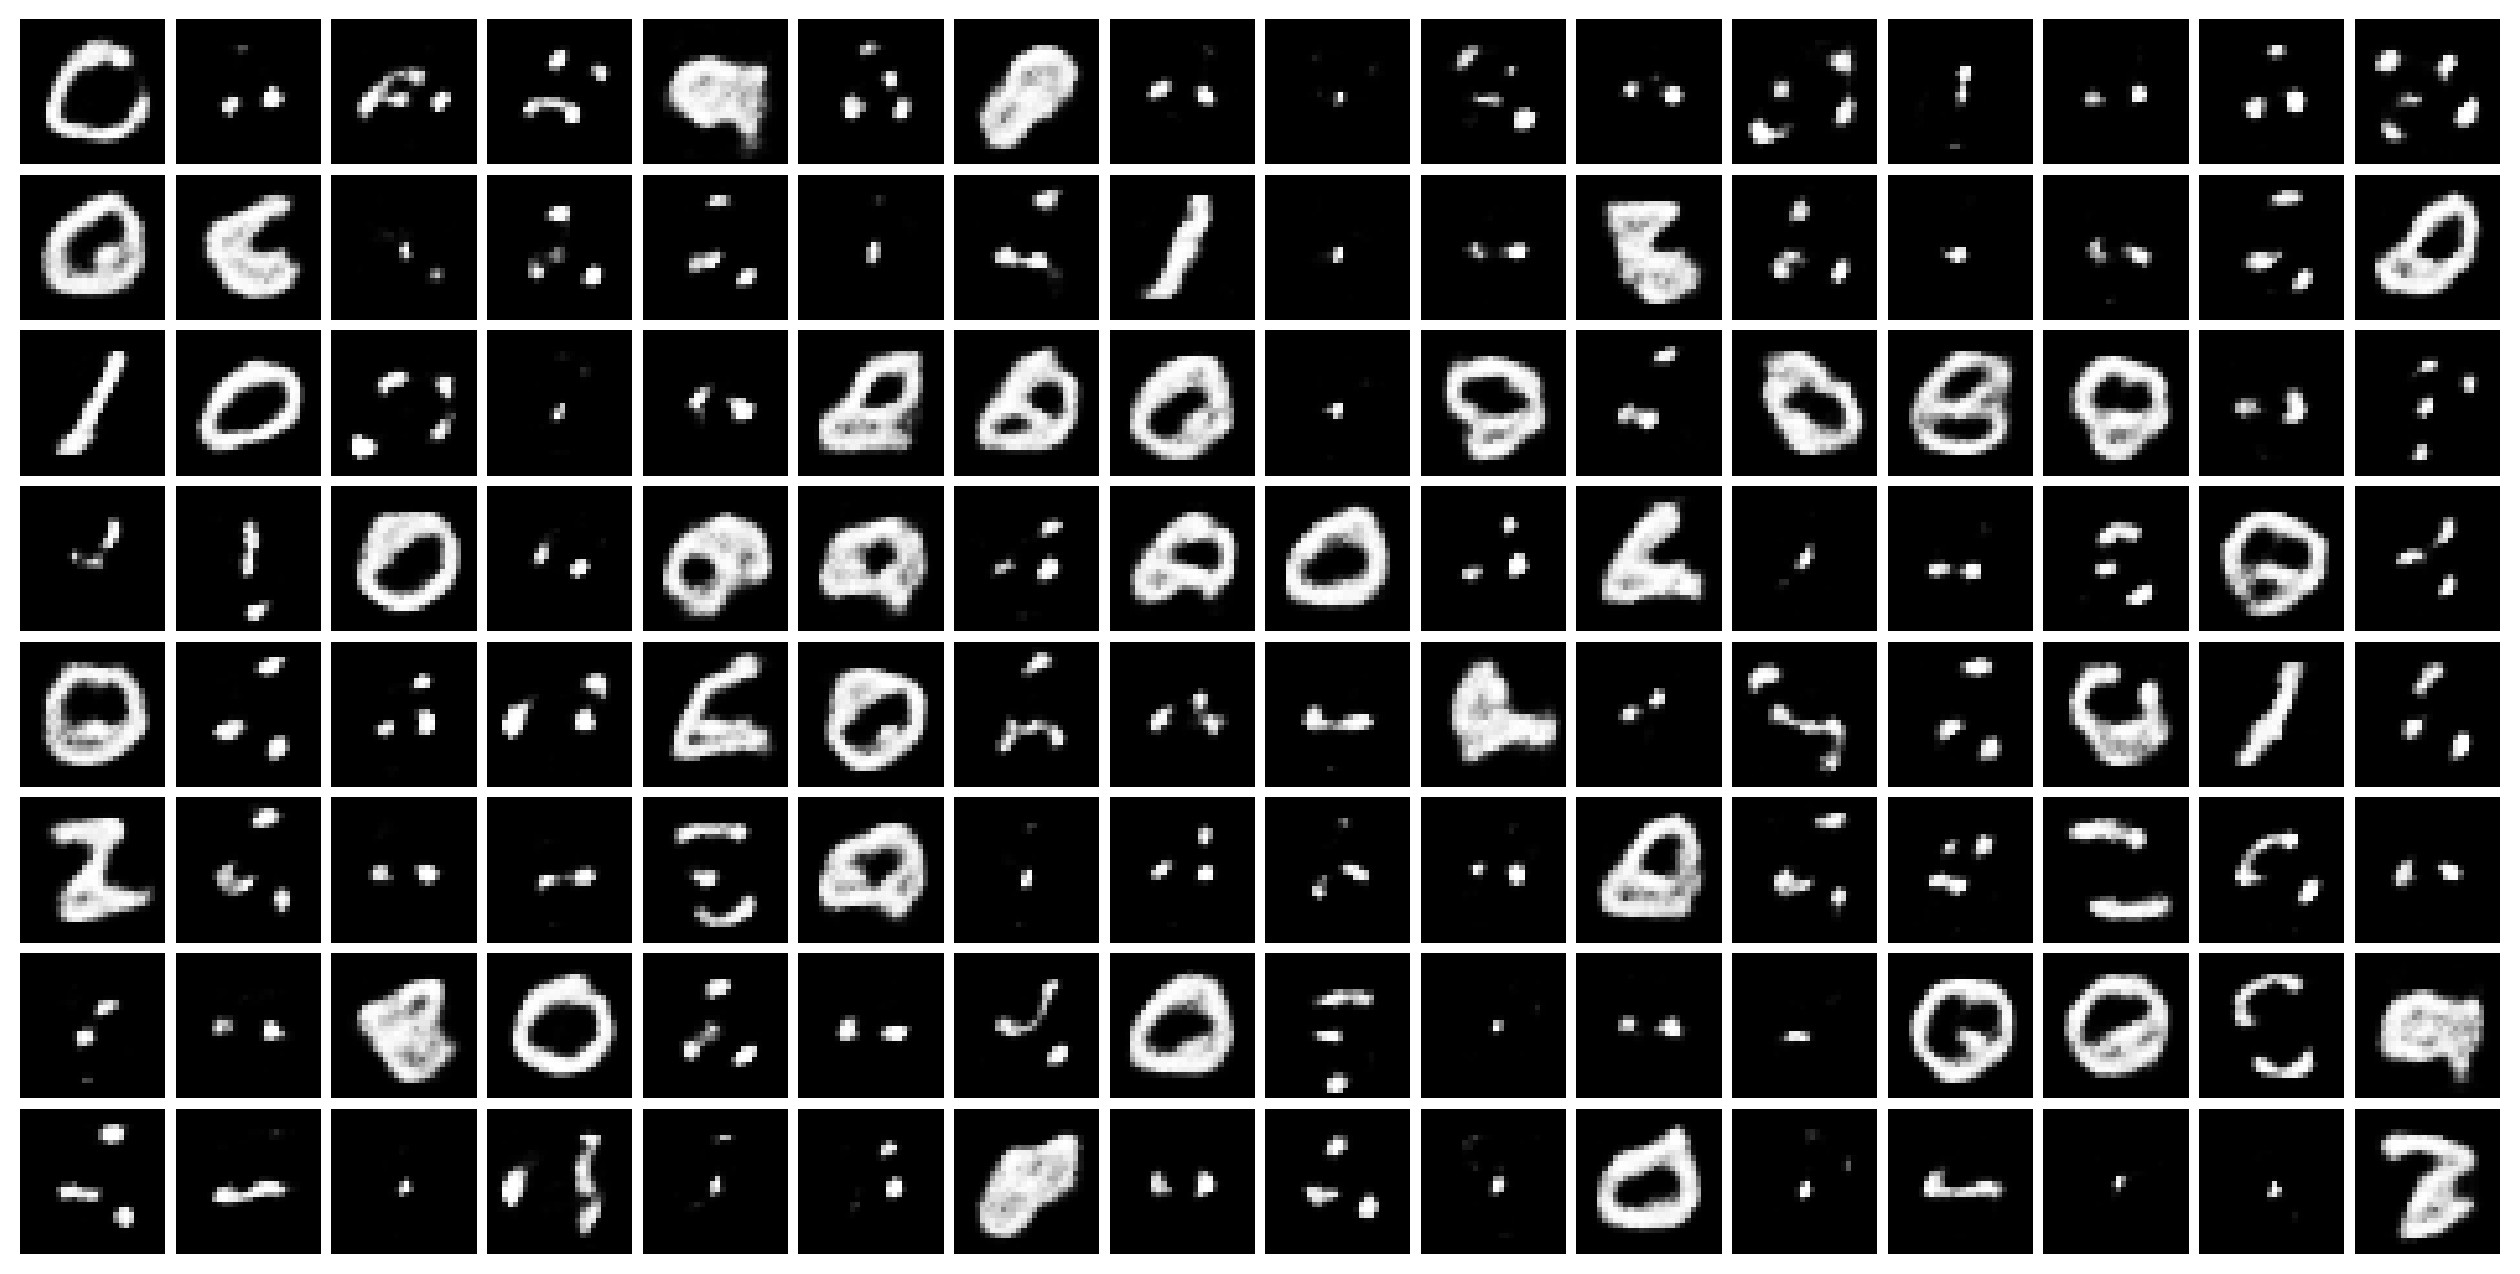

In [18]:
draw_layer_samples(dbn, 0, monitoring_set[:8 * 16])

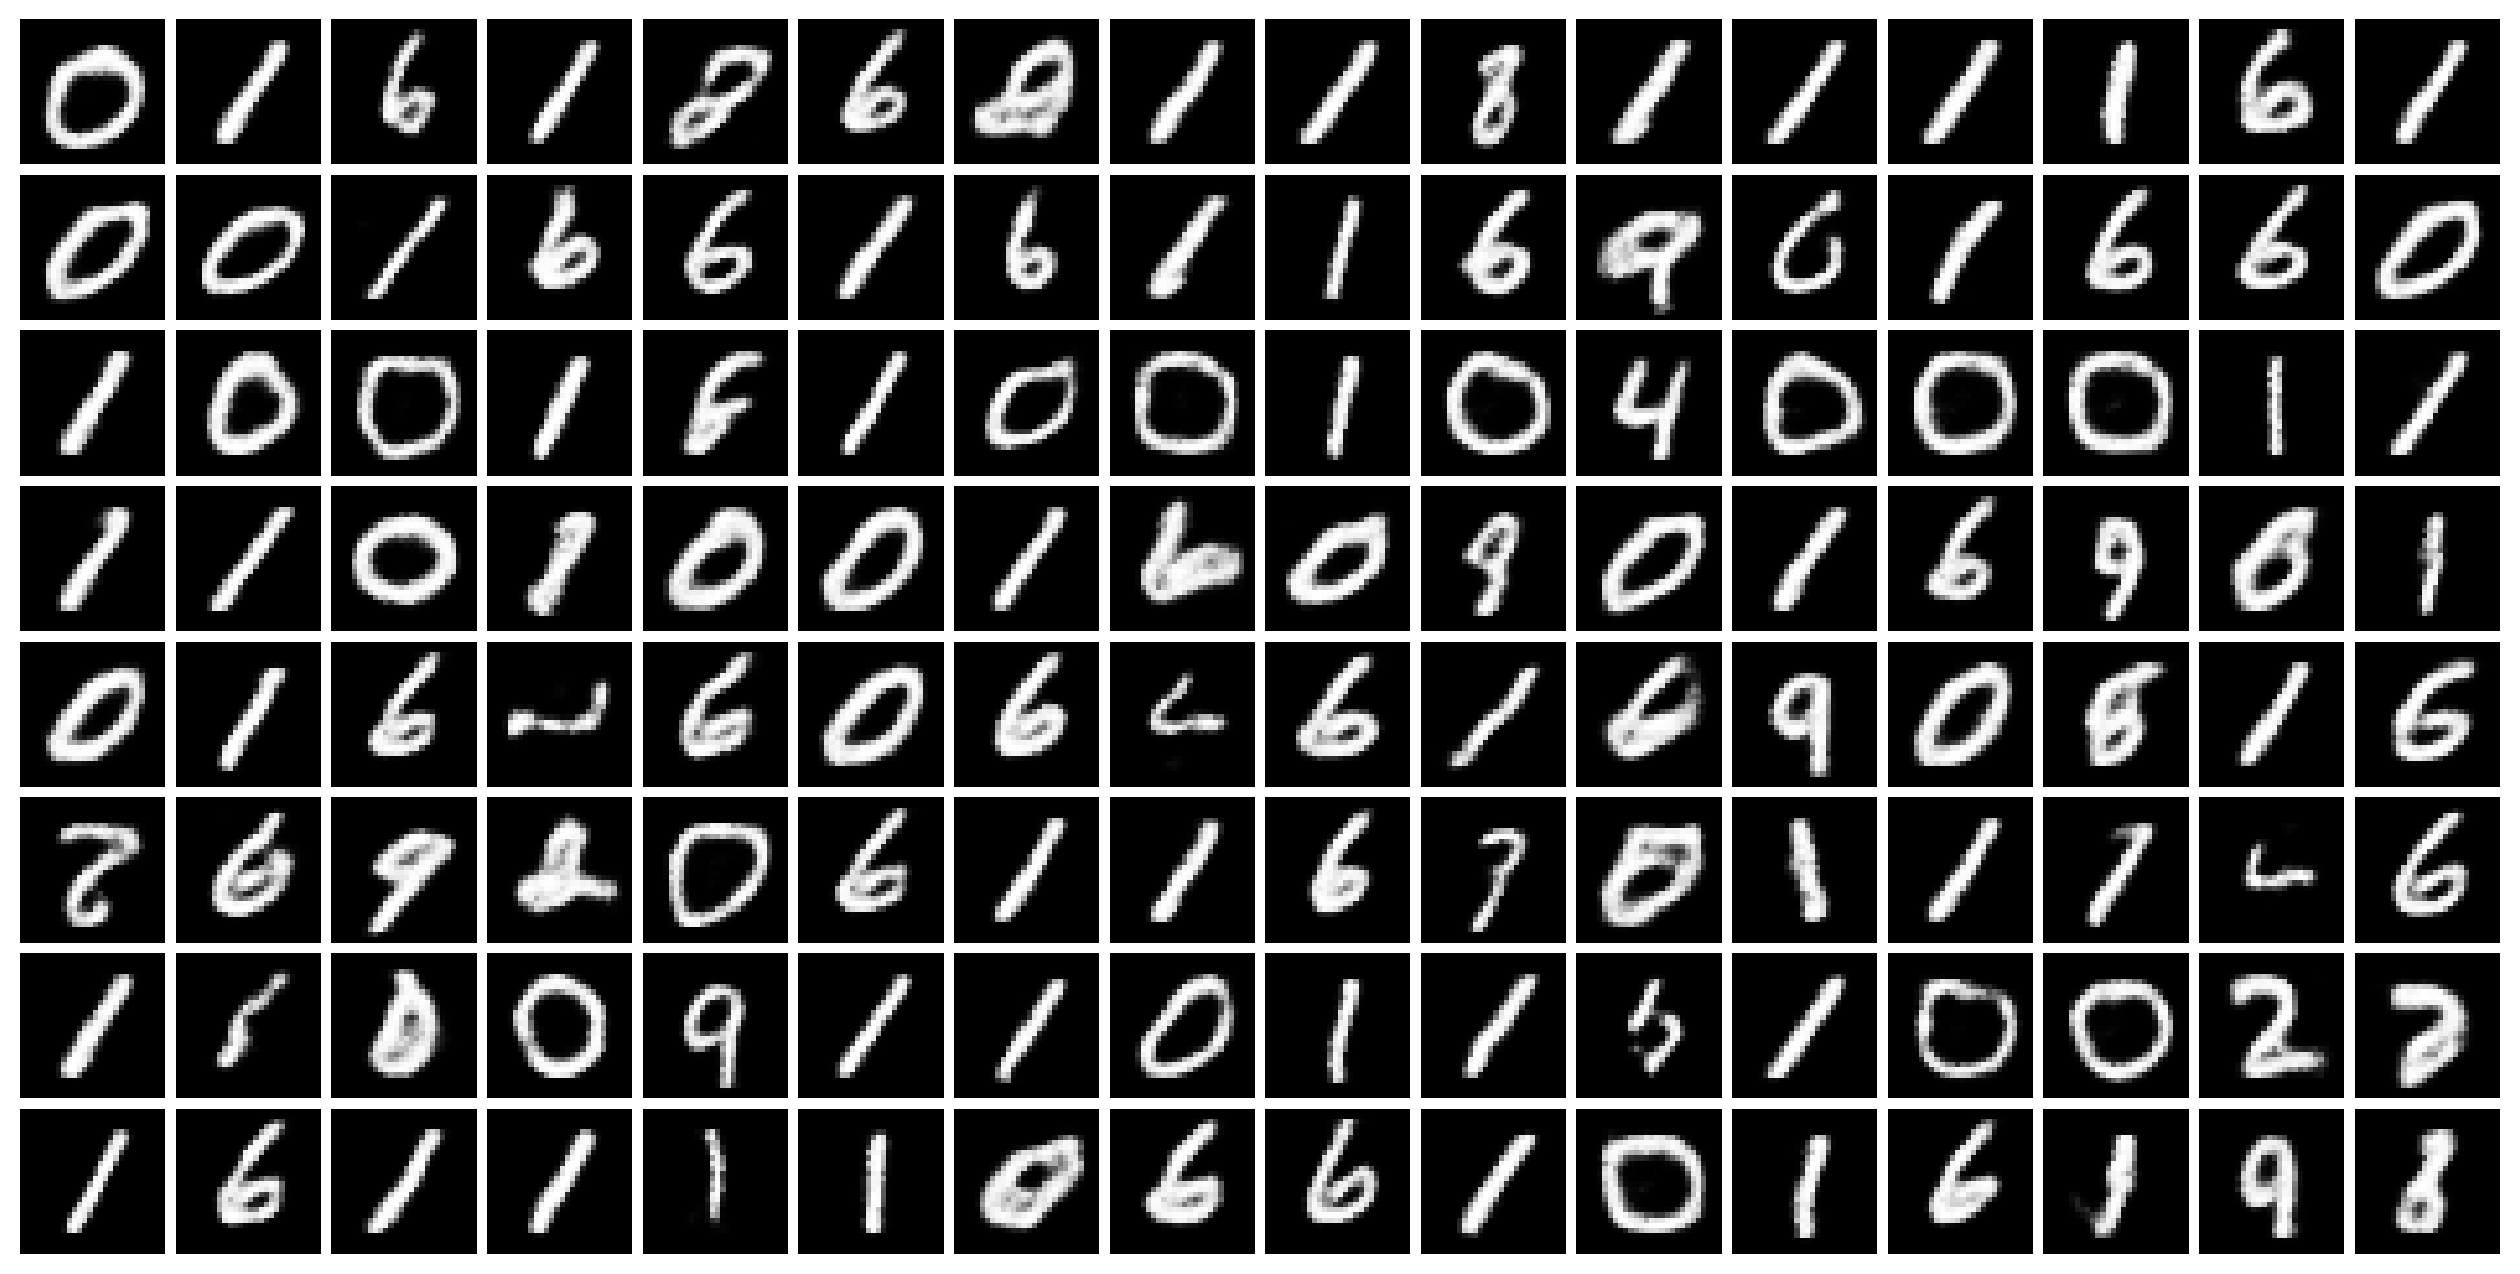

In [19]:
draw_layer_samples(dbn, 1, monitoring_set[:8 * 16])

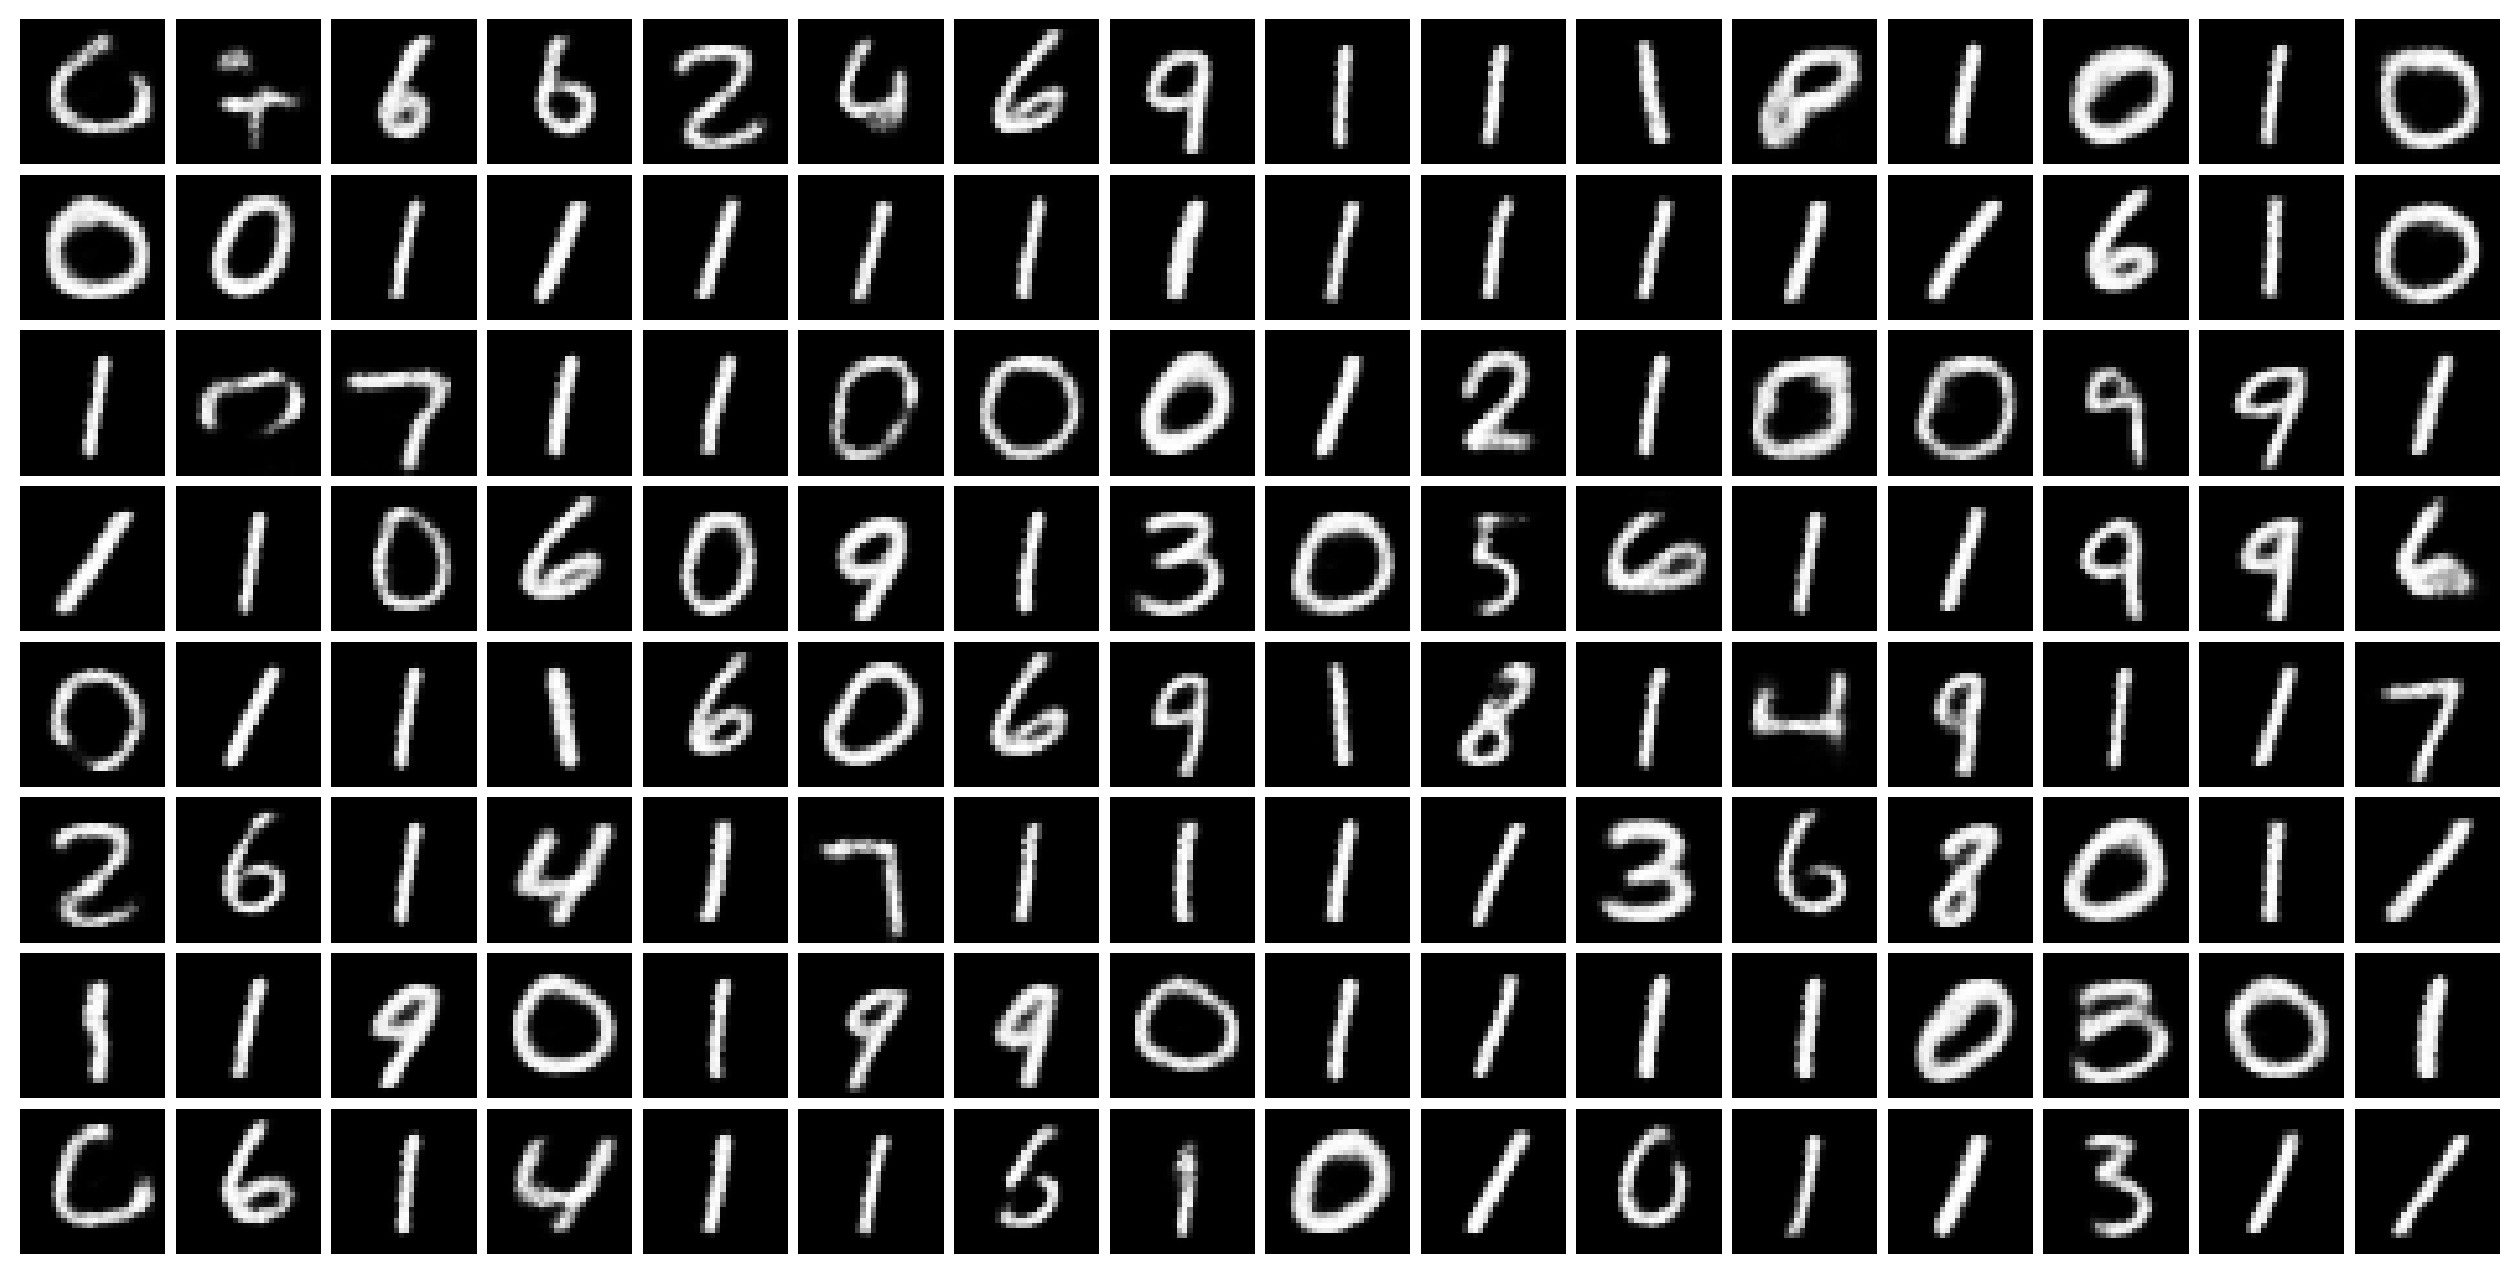

In [20]:
draw_layer_samples(dbn, 2, monitoring_set[:8 * 16])